In [58]:
import numpy as np 
import pandas as pd
from datetime import datetime
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors

In [59]:

class CatchesSSSCorrelator:
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.catches_data = pd.DataFrame()
        self.sss_data = xr.Dataset()
        self.sss_weekly = xr.Dataset()
        self.sss_df = pd.DataFrame()
        self.merge_datasets = pd.DataFrame()
        self.results = pd.DataFrame()
        self.grouped = pd.DataFrame()
        
    def load_catches_data(self, filename):
        self.catches_data = pd.read_csv(self.data_dir / filename)

    def load_sss_data(self, filepath):
        self.sss_data = xr.open_dataset(filepath)

    def preprocess_catches_data(self):
        def parse_temporada(row):
            parte, anio = row.split()
            return int(anio)
        self.catches_data["anio"] = self.catches_data["temporada"].apply(parse_temporada)
        self.catches_data["fecha"] = pd.to_datetime(
            self.catches_data["anio"].astype(str), format="%Y"
        ) + pd.to_timedelta((self.catches_data["semana"] - 1) * 7, unit="D")

    def preprocess_sss_data(self):
        years = np.arange(2015, 2025)
        ds_list = []
        for y in years:
            ds_year = self.sss_data.sel(time=slice(f"{y}-01-01", f"{y}-12-31"))
            ds_year_weekly = ds_year.resample(time="7D", origin=f"{y}-01-01").max()            # media de SSS semanal
            ds_list.append(ds_year_weekly)

        sss_weekly = xr.concat(ds_list, dim="time")

        semanas = sss_weekly["time"].dt.isocalendar().week
        mask_temporada1 = (semanas >= 14) & (semanas <= 32)
        mask_temporada2 = (semanas >= 42) | (semanas <= 5)
        mask_temporadas = mask_temporada1 | mask_temporada2

        self.sss_weekly = sss_weekly.where(mask_temporadas, drop=True)

    def convert_xarray_to_dataframe(self):
        if "sss" not in self.sss_weekly.data_vars:
            raise ValueError("El dataset no contiene la variable 'sss'")
        df = self.sss_weekly["sss"].to_dataframe().reset_index()
        df["semana"] = df["time"].dt.isocalendar().week
        df.rename(columns={"latitude": "lat_bin", "longitude": "lon_bin", "time": "fecha"}, inplace=True)

        self.sss_df = df
    
    def merge_datasets_catches_sss(self):
        if self.catches_data.empty or self.sss_df.empty:
            raise ValueError("Ambos datasets deben estar cargados y preprocesados")
        merged = pd.merge(
            self.catches_data[["fecha", "lat_bin", "lon_bin", "suma_pescado", "temporada"]],
            self.sss_df[["fecha", "lat_bin", "lon_bin", "sss"]],
            on=["fecha", "lat_bin", "lon_bin"],
            how="inner"
        )

        self.merge_datasets = merged[merged["suma_pescado"] != 0]
    

    def grouped_merged(self, step=3):

        merged = self.merge_datasets

        if step == 1:
            self.grouped = merged.copy()
            return

        df = merged.copy()
        df["lat_idx"] = df["lat_bin"].rank(method="dense").astype(int)
        df["lon_idx"] = df["lon_bin"].rank(method="dense").astype(int)

        df["lat_block"] = (df["lat_idx"] // step)
        df["lon_block"] = (df["lon_idx"] // step)

        df["lat_center"] = df.groupby("lat_block")["lat_bin"].transform("mean")
        df["lon_center"] = df.groupby("lon_block")["lon_bin"].transform("mean")

        grouped = (
            df.groupby(["fecha","temporada","lat_block","lon_block"], as_index=False)
            .agg({
                "suma_pescado": "sum",
                "sss": "mean",              # media de SSS en el bloque
                "lat_center": "first",
                "lon_center": "first"
            })
            .rename(columns={"lat_center": "lat_bin", "lon_center": "lon_bin"})
        )

        self.grouped = grouped

    def correlate(self):

        results = []
        grouped = self.grouped
        for (lat, lon), df_group in grouped.groupby(["lat_bin", "lon_bin"]):
            n_registros = df_group.shape[0]
            if n_registros > 21:
                corr = df_group[["suma_pescado", "sss"]].corr().iloc[0,1]
                results.append({"lat": lat, "lon": lon, "correlation": corr, "n_registros": n_registros})
        self.results = pd.DataFrame(results)

    def save_results(self, output_filename):
        self.results.to_csv(self.data_dir / output_filename, index=False)

    def scatter_plot_sss_catches(self, log_scale=False, alpha=0.6, figsize=(10, 6)):
        """
        Crea un scatter plot de todos los registros de SSS vs capturas.
        
        Parameters:
        -----------
        log_scale : bool, default False
            Si True, aplica escala logarítmica al eje Y (capturas)
        alpha : float, default 0.6
            Transparencia de los puntos (0-1)
        figsize : tuple, default (10, 6)
            Tamaño de la figura
        """
        if self.merge_datasets.empty:
            raise ValueError("Primero debes ejecutar merge_datasets_catches_sss()")
        
        fig, ax = plt.subplots(figsize=figsize)
        
        # Crear el scatter plot
        scatter = ax.scatter(
            self.merge_datasets['sss'], 
            self.merge_datasets['suma_pescado'],
            alpha=alpha,
            s=20,
            c='steelblue',
            edgecolors='none'
        )
        
        # Calcular correlación general
        corr_total = self.merge_datasets[['sss', 'suma_pescado']].corr().iloc[0, 1]
        n_total = len(self.merge_datasets)
        
        # Configurar ejes
        ax.set_xlabel('Salinidad Superficial (PSU)', fontsize=12)
        ax.set_ylabel('Capturas (kg)', fontsize=12)
        
        if log_scale:
            ax.set_yscale('log')
            ax.set_ylabel('Capturas (kg) - Escala log', fontsize=12)
        
        # Título con estadísticas
        ax.set_title(f'SSS vs Capturas - Correlación: {corr_total:.3f} (n={n_total:,})', 
                    fontsize=14, fontweight='bold')
        
        # Agregar línea de tendencia (con manejo de errores)
        try:
            # Filtrar valores válidos para la regresión
            valid_data = self.merge_datasets[['sss', 'suma_pescado']].dropna()
            if len(valid_data) > 10:  # Necesitamos suficientes puntos
                z = np.polyfit(valid_data['sss'], valid_data['suma_pescado'], 1)
                p = np.poly1d(z)
                x_trend = np.linspace(valid_data['sss'].min(), valid_data['sss'].max(), 100)
                ax.plot(x_trend, p(x_trend), 
                       "r--", alpha=0.8, linewidth=2, label=f'Tendencia (r={corr_total:.3f})')
        except (np.linalg.LinAlgError, ValueError) as e:
            print(f"No se pudo calcular la línea de tendencia: {e}")
            # Solo mostrar correlación sin línea
            pass
        
        # Agregar estadísticas en el plot
        textstr = f'Media SSS: {self.merge_datasets["sss"].mean():.2f} PSU\n'
        textstr += f'Media capturas: {self.merge_datasets["suma_pescado"].mean():.1f} kg\n'
        textstr += f'Registros: {n_total:,}'
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return corr_total, n_total

    def visualizar_correlacion(self, shapefile_path=None, mode="grid"):
    
        if self.results.empty:
            raise ValueError("Primero debes correr el método correlate()")

        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes([0.05, 0.05, 0.85, 0.9])

        if shapefile_path:
            boundary = gpd.read_file(shapefile_path)
            boundary.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5)

        if mode == "scatter":
            sc = ax.scatter(
                self.results["lon"],
                self.results["lat"],
                c=self.results["correlation"],
                cmap="RdBu_r",
                vmin=-1, vmax=1,
                s=50
            )
            cbar = plt.colorbar(sc, ax=ax, label="Correlación")

        elif mode == "grid":
            grid = self.results.pivot_table(
                index="lat", columns="lon", values="correlation"
            )
            lons = grid.columns.values
            lats = grid.index.values
            Z = grid.values

            levels = np.linspace(-1, 1, 21)
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            mesh = ax.pcolormesh(
                lons, lats, Z,
                cmap="RdBu_r", norm=norm,
                shading="auto"
            )

            cax = plt.axes([0.92, 0.1, 0.02, 0.8])

            plt.colorbar(mesh, cax=cax, ticks=levels, label="Correlación")

        else:
            raise ValueError("mode debe ser 'scatter' o 'grid'")

        ax.set_xlim([-83, -74.5])  # ajusta a tu dominio
        ax.set_ylim([-16, -4])
        ax.set_xlabel("Longitud")
        ax.set_ylabel("Latitud")
        ax.set_title("Mapa de correlación capturas–SSS", fontsize=10, loc="left")

        plt.show()

#        fig.savefig(self.data_dir / "correlation_map.png", bbox_inches="tight", dpi=300)


In [60]:

data_dir = "/home/jupyter-daniela/suyana/peru_production/outputs/"
sss_path = "/home/jupyter-daniela/suyana/peru_production/features/OISSS_sss_weekly_2015-2024_4N_74W_16S_83W_0.25deg.nc"
csc = CatchesSSSCorrelator(data_dir)


In [61]:

csc.load_catches_data("calas_grillado_semanal_grilla_SSS.csv")
csc.load_sss_data(sss_path)
csc.preprocess_catches_data()
csc.preprocess_sss_data()
csc.convert_xarray_to_dataframe()
csc.merge_datasets_catches_sss()
csc.grouped_merged(step=1)
csc.correlate()

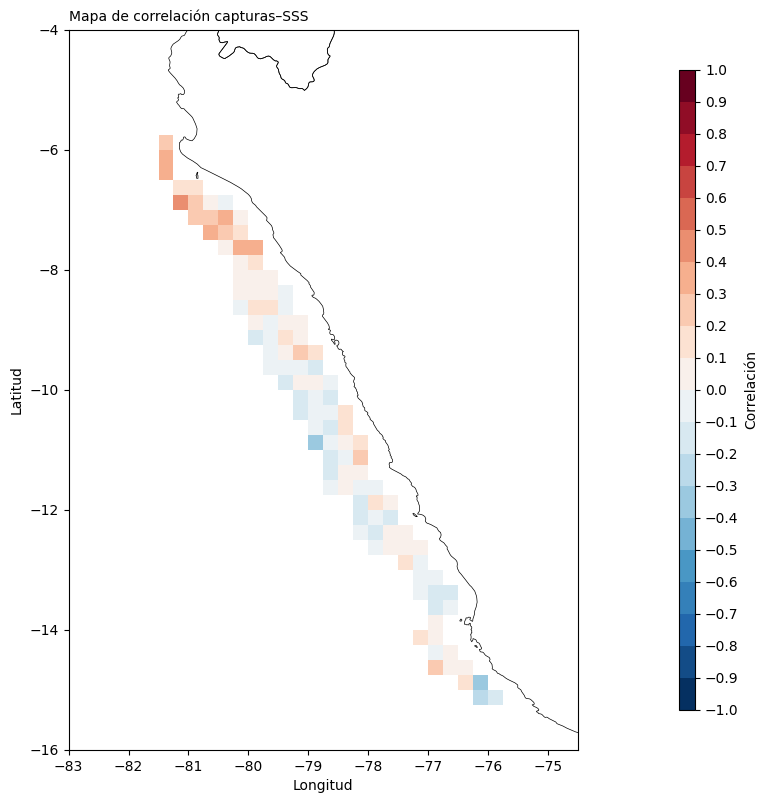

In [62]:
csc.visualizar_correlacion(
    shapefile_path="/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp",
    mode="grid"
)

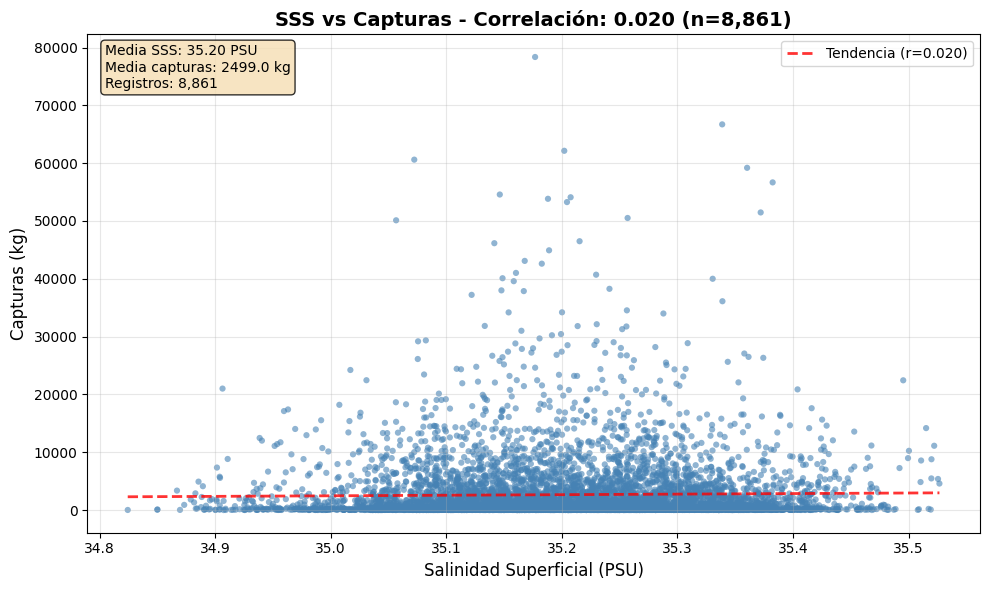

In [63]:
# Uso básico
corr, n = csc.scatter_plot_sss_catches()
